#### Imports

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LogisticRegressionCV as LRCV

from sklearn.linear_model import Lasso, LassoCV
import matplotlib.pyplot as plt
import sklearn.metrics

n_folds = 5

#### Load and preprocess data

In [ ]:
X = pd.read_csv('data.csv', index_col=0).to_numpy()
y = pd.read_csv('labels.csv')['Class']
unique_labels = y.unique()
y = y.replace(unique_labels, list(range(len(unique_labels)))).to_numpy()



In [ ]:
X = SelectKBest(score_func=f_classif, k=200).fit_transform(X, y)

def train_val_split(X,y, train_frac=0.8):
    N = int(X.shape[0]*train_frac)
    X_train = X[:N] 
    X_val = X[N:]
    y_train = y[:N]
    y_val =  y[N:]
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = train_val_split(X,y)


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    5    23  4370  4808  4809  4814  4816  4817  4831  5288  7661  7662
  7663  7664  7665  8121  9304  9306  9314  9316  9320  9452 10121 11958
 13991 14158 14159 14161 15138 15140 15141 15446 16566 16568 16569 16571
 16575 16578 16579 16604 16634 16637 16677 16697 16698 16699 16700 16701
 16702 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714
 16715 16716 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726
 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738
 16739 16740 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751
 16752 16753 16754 16756 16757 16758 16759 16760 16761 16762 16763 16764
 16765 16766 16767 16768 16769 16770 16771 16772 16774 16775 16776 16777
 16778 16779 16780 16781 16782 16783 16785 16787 16788 16789 16790 16791
 16792 16794 16795 16796 16798 16799 16800 16801 16802 16803 1680

In [ ]:
#lrcv = LRCV(cv = 5, Cs=np.logspace(-4,5,30),scoring='accuracy', multi_class='ovr', solver='liblinear').fit(X_train, y_train)
cs = np.logspace(-4,5,30)
lrcv = LRCV(penalty='l1',scoring='f1', multi_class='ovr', solver='liblinear', intercept_scaling=10000, cv=n_folds,Cs = cs)
lrcv.fit(X_train, y_train)
C_ = lrcv.C_
print(np.array(lrcv.scores_).shape)
print(C_)
#average lambda over each folds
#for each lambda, 5 different f-scores
#average and take standard deviation from that



()
[3.56224789e-03 3.29034456e+02 4.52035366e+00 4.52035366e+00
 1.37382380e+03]


#### Perform feature selection

In [ ]:
def get_best_feature_indices(scores):
    best_feature_index = {}
    for key in scores:
        score = np.mean(scores[key], axis=0)
        score_max = np.max(score)
        score_std = np.std(score)

        C_1se = np.min(score[score > (score_max - score_std)])
        C_1se_index = np.array(np.argwhere(score == C_1se)).flatten()

        best_feature_index.update({key: C_1se_index})

    return best_feature_index



In [ ]:
best_feature_index = list(get_best_feature_indices(lrcv.scores_).values())
best_feature_index = np.array(best_feature_index).flatten()
print(best_feature_index)
C_1se = np.min(cs[best_feature_index])
print(C_1se)

[4 4 4 5 6]
0.0017433288221999873


In [ ]:
lr = LR(penalty='l1', C=C_1se,multi_class='ovr' , solver='liblinear', intercept_scaling=10000).fit(X_train, y_train)
#print(lr.coef_)
pred = lr.predict(X_val)
sklearn.metrics.f1_score(y_val, pred, average=None)

array([0.98245614, 1.        , 0.9375    , 0.98412698, 0.6       ])

In [ ]:
import collections
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score, v_measure_score


lr_min_coefs = LR(penalty='l1', C=C_[0],multi_class='ovr' , solver='liblinear', intercept_scaling=10000).fit(X_train, y_train)
lr_1se_coefs = LR(penalty='l1', C=C_1se, multi_class='ovr' , solver='liblinear', intercept_scaling=10000).fit(X_train,y_train)

#print(lr_1se_coefs.coef_)


"""
#print(f"Silhouette score: {metrics.silhouette_score(components, predictions, metric='euclidean')}")
print(f"Homogeneity score: {homogeneity_score(newlabels, predictions)}")
print(f"V-score: {metrics.v_measure_score(newlabels, predictions)}")
fig = plt.figure(figsize = (10,10) )
ax = plt.axes(projection='3d')
x = components[:, 0]
y = components[:, 1]
z = components[:, 2]
ax.scatter3D(x, y, z, c=predictions);
"""

'\n#print(f"Silhouette score: {metrics.silhouette_score(components, predictions, metric=\'euclidean\')}")\nprint(f"Homogeneity score: {homogeneity_score(newlabels, predictions)}")\nprint(f"V-score: {metrics.v_measure_score(newlabels, predictions)}")\nfig = plt.figure(figsize = (10,10) )\nax = plt.axes(projection=\'3d\')\nx = components[:, 0]\ny = components[:, 1]\nz = components[:, 2]\nax.scatter3D(x, y, z, c=predictions);\n'

# arrr matey, pirates be bootstraping

In [ ]:
def create_samples(X,y, M, frac=0.8):
    samples_X = []
    samples_y = []
    for m in range(M):
        N_rows = int(X.shape[0]*frac)
        selected_idx = np.random.choice(np.arange(X.shape[0]), size=N_rows, replace=False)
        samples_X.append(X[selected_idx])
        samples_y.append(y[selected_idx])
    return np.array(samples_X), np.array(samples_y)

M = 20
samples_X, samples_y = create_samples(X_train, y_train, M)

In [ ]:

def select_features(samples_X,samples_y):
    
    times_selected = np.zeros(samples_X.shape[2])
    times_selected_per_class = np.zeros((5,samples_X.shape[2]))
    for i in range(samples_X.shape[0]): 
        X = samples_X[i] 
        y = samples_y[i]
        lrcv.fit(X,y)
        best_feature_index = list(get_best_feature_indices(lrcv.scores_).values())
        best_feature_index = [elem[0] for elem in best_feature_index]
        best_feature_index = np.array(best_feature_index).flatten()
        C_1se = np.min(cs[best_feature_index])
        
        lr_1se_coefs = LR(penalty='l1', C=C_1se, multi_class='ovr' , solver='liblinear', intercept_scaling=10000).fit(X,y).coef_
        lr_1se_coefs = np.array(lr_1se_coefs)
        j = 0
        for coef in lr_1se_coefs:
            coef = np.array(coef)
            times_selected += coef != 0
            times_selected_per_class[j] += coef != 0
            j += 1
        #print(times_selected)
    return times_selected, times_selected_per_class




times_selected, times_selected_per_class = select_features(samples_X,samples_y) 


[ 0.  0.  0.  0.  0.  0. 19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  4.  0.
  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0. 13.
  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[98, 153, 86, 33, 34]
[1.  1.  1.  1.  0.2]


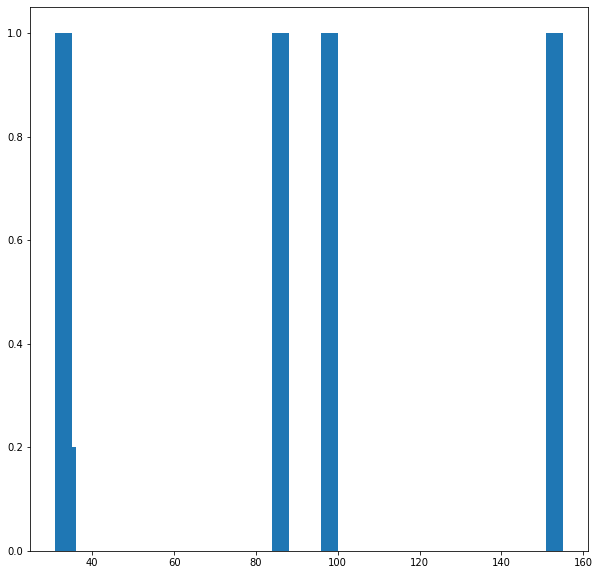

In [ ]:
print(times_selected)
plt.figure(figsize=(10,10))
#plt.subplot(121)
#plt.bar(np.arange(times_selected.shape[0]), times_selected/(20*5), width=4)
most_important_per_class = [np.argmax(count) for count in times_selected_per_class]
#plt.subplot(122)
plt.bar(most_important_per_class, np.max(times_selected_per_class, axis=1)/M, width=4)
print(most_important_per_class)
print(np.max(times_selected_per_class, axis=1)/M)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f98e27f7-6444-4cf3-8fec-73bc47540f9b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>